## Notebook for visualisation testing

In [208]:
import numpy as np
import pandas as pd
import sys

In [209]:
sys.path.append('d:/gsn-projekt')

In [2]:
confmat = np.array([[10,2,0],
                    [3,15,1],
                    [1,4,20]])

In [3]:
confmat

array([[10,  2,  0],
       [ 3, 15,  1],
       [ 1,  4, 20]])

Code from [https://github.com/wcipriano/pretty-print-confusion-matrix](https://github.com/wcipriano/pretty-print-confusion-matrix) 

In [210]:
from amphibian.visual import ConfusionMatrix

In [83]:
cm = ConfusionMatrix(confmat)

In [84]:
cm.compute_metrics()

array([[10.        ,  2.        ,  0.        ,  0.83333333],
       [ 3.        , 15.        ,  1.        ,  0.78947368],
       [ 1.        ,  4.        , 20.        ,  0.8       ],
       [ 0.71428571,  0.71428571,  0.95238095,  0.80357143]])

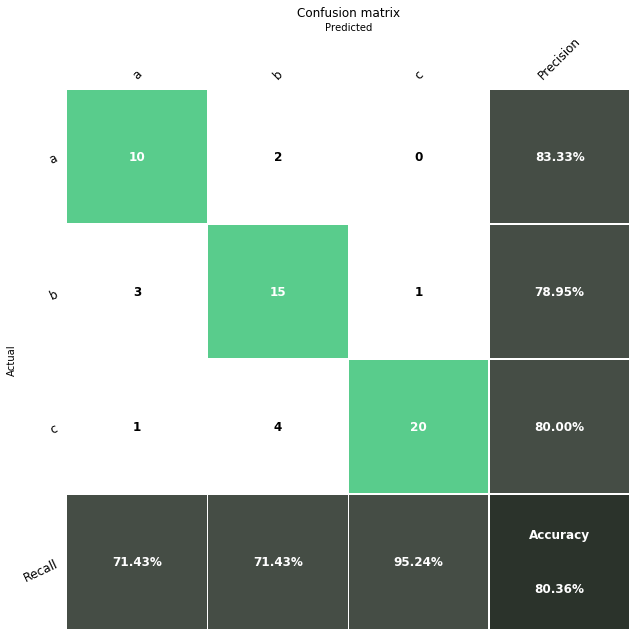

In [211]:
ConfusionMatrix(confmat, ['a', 'b', 'c']).plot()

In [187]:
a = plt.figure('dupa', (9,9))

<Figure size 648x648 with 0 Axes>

<Figure size 648x648 with 0 Axes>

In [160]:
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sns


def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1


def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del
#

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['Precision'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['Recall'] = sum_col

    
def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sns.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)
    
    # Move xaxis ticks to top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show()
#


[]

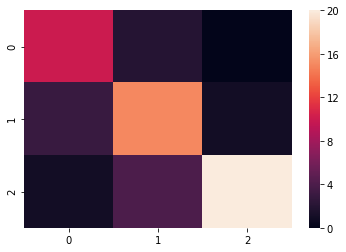

In [93]:
a = sn.heatmap(confmat)
a.collections[0].axes.texts

([], [])
([], [])
([], [])
([{'x': 3.5, 'y': 0.2, 'text': '14', 'kw': {'color': 'w', 'ha': 'center', 'va': 'center', 'gid': 'sum', 'fontproperties': <matplotlib.font_manager.FontProperties object at 0x000002E3FEA9FB70>}}, {'x': 3.5, 'y': 0.5, 'text': '71.43%', 'kw': {'color': 'g', 'ha': 'center', 'va': 'center', 'gid': 'sum', 'fontproperties': <matplotlib.font_manager.FontProperties object at 0x000002E3FEA9FB70>}}, {'x': 3.5, 'y': 0.8, 'text': '28.57%', 'kw': {'color': 'r', 'ha': 'center', 'va': 'center', 'gid': 'sum', 'fontproperties': <matplotlib.font_manager.FontProperties object at 0x000002E3FEA9FB70>}}], [Text(3.5, 0.5, '14.00')])
([], [])
([], [])
([], [])
([{'x': 3.5, 'y': 1.2, 'text': '21', 'kw': {'color': 'w', 'ha': 'center', 'va': 'center', 'gid': 'sum', 'fontproperties': <matplotlib.font_manager.FontProperties object at 0x000002E3FEA7B668>}}, {'x': 3.5, 'y': 1.5, 'text': '71.43%', 'kw': {'color': 'g', 'ha': 'center', 'va': 'center', 'gid': 'sum', 'fontproperties': <matplotli

d:\gsn-projekt\venv\lib\site-packages\ipykernel_launcher.py:49: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


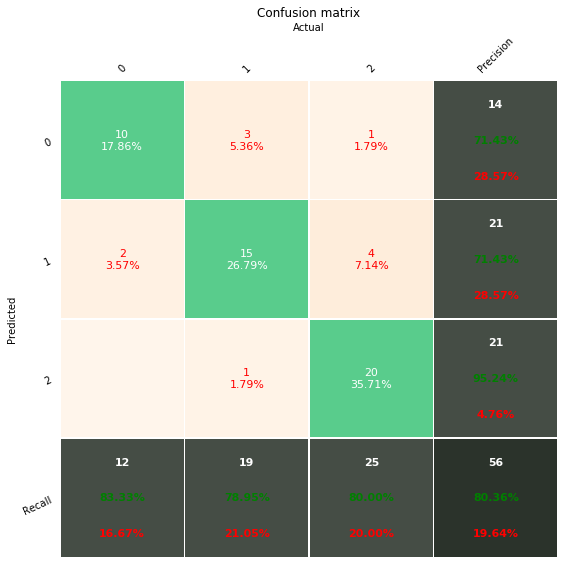

In [18]:
pretty_plot_confusion_matrix(pd.DataFrame(confmat))